In [1]:
!pip install transformers
!pip install sentencepiece
!pip install --user -U nltk

import pandas as pd
import os
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers.optimization import  Adafactor 
import time
import warnings
warnings.filterwarnings('ignore')
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.translate.meteor_score import meteor_score

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
actor1 = {'0':'', '1': 'STATE FORCES', '2': 'REBEL GROUPS', '3': 'POLITICAL MILITIAS', '4':'IDENTITY MILITIAS', '5': 'RIOTERS', '6':'PROTESTERS', '7':'CIVILIANS', '8':'OTHERS'}
actor2 = {'0':'', '1': 'STATE FORCES', '2': 'REBEL GROUPS', '3': 'POLITICAL MILITIAS', '4':'IDENTITY MILITIAS', '5': 'RIOTERS', '6':'PROTESTERS', '7':'CIVILIANS', '8':'OTHERS'}


In [3]:
interaction = {}
for i in range(10, 81):
  digit1, digit2 = str(i)[0], str(i)[1]
  if digit1 != '9' and digit2 != '9':
    if digit2 == '0':
      interaction[str(i)] = "SOLE "  + actor1[digit1] + " ACTION"
    else:
      interaction[str(i)] =  actor1[digit1] + " VERSUS " + actor2[digit2]

interaction


{'10': 'SOLE STATE FORCES ACTION',
 '11': 'STATE FORCES VERSUS STATE FORCES',
 '12': 'STATE FORCES VERSUS REBEL GROUPS',
 '13': 'STATE FORCES VERSUS POLITICAL MILITIAS',
 '14': 'STATE FORCES VERSUS IDENTITY MILITIAS',
 '15': 'STATE FORCES VERSUS RIOTERS',
 '16': 'STATE FORCES VERSUS PROTESTERS',
 '17': 'STATE FORCES VERSUS CIVILIANS',
 '18': 'STATE FORCES VERSUS OTHERS',
 '20': 'SOLE REBEL GROUPS ACTION',
 '21': 'REBEL GROUPS VERSUS STATE FORCES',
 '22': 'REBEL GROUPS VERSUS REBEL GROUPS',
 '23': 'REBEL GROUPS VERSUS POLITICAL MILITIAS',
 '24': 'REBEL GROUPS VERSUS IDENTITY MILITIAS',
 '25': 'REBEL GROUPS VERSUS RIOTERS',
 '26': 'REBEL GROUPS VERSUS PROTESTERS',
 '27': 'REBEL GROUPS VERSUS CIVILIANS',
 '28': 'REBEL GROUPS VERSUS OTHERS',
 '30': 'SOLE POLITICAL MILITIAS ACTION',
 '31': 'POLITICAL MILITIAS VERSUS STATE FORCES',
 '32': 'POLITICAL MILITIAS VERSUS REBEL GROUPS',
 '33': 'POLITICAL MILITIAS VERSUS POLITICAL MILITIAS',
 '34': 'POLITICAL MILITIAS VERSUS IDENTITY MILITIAS',
 '35

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import pandas as pd

In [6]:
train = pd.read_csv('/content/drive/MyDrive/project_2_data/task_2/task_2_event_summarization_train.tsv', sep='\t')

In [7]:
train.head()

,EVENT_DATE,SOURCE,FATALITIES,EVENT_TYPE,SUB_EVENT_TYPE,ACTOR1,INTER1,ACTOR2,INTER2,INTERACTION,LOCATION,NOTES
0,18-December-2019,Vanguard (Nigeria),0,Protests,Peaceful protest,Protesters (Nigeria),6,NaN,0,60,Iwhreka,"On 18 December 2019, tens of women demonstrate..."
1,19-December-2019,Daily Trust (Nigeria); Nigeria Punch,0,Protests,Peaceful protest,Protesters (Nigeria),6,NaN,0,60,Abuja,"On 19 December 2019, employees of NIPOST in Ab..."
2,03-September-2019,Legit,0,Battles,Armed clash,Unidentified Armed Group (Nigeria),3,Police Forces of Nigeria (2015-),1,13,Ijaw,03 September. Unidentified gunmen attacked the...
3,16-October-2019,Nigeria Punch,0,Violence against civilians,Abduction/forced disappearance,Unidentified Armed Group (Nigeria),3,Civilians (Nigeria),7,37,Sofo-Birnin-Gwari,16 October 2019. Unidentified gunmen opened fi...
4,01-May-2021,News24 (South Africa),0,Protests,Peaceful protest,Protesters (South Africa),6,NaN,0,60,Oudtshoorn,"Around 1 May 2021 (weekend of), PARCSA support..."


In [8]:
train['processed_interaction'] = train['INTERACTION'].astype(str)
train['processed_interaction'] = train['processed_interaction'].map(interaction)

In [9]:
train.head()

,EVENT_DATE,SOURCE,FATALITIES,EVENT_TYPE,SUB_EVENT_TYPE,ACTOR1,INTER1,ACTOR2,INTER2,INTERACTION,LOCATION,NOTES,processed_interaction
0,18-December-2019,Vanguard (Nigeria),0,Protests,Peaceful protest,Protesters (Nigeria),6,NaN,0,60,Iwhreka,"On 18 December 2019, tens of women demonstrate...",SOLE PROTESTERS ACTION
1,19-December-2019,Daily Trust (Nigeria); Nigeria Punch,0,Protests,Peaceful protest,Protesters (Nigeria),6,NaN,0,60,Abuja,"On 19 December 2019, employees of NIPOST in Ab...",SOLE PROTESTERS ACTION
2,03-September-2019,Legit,0,Battles,Armed clash,Unidentified Armed Group (Nigeria),3,Police Forces of Nigeria (2015-),1,13,Ijaw,03 September. Unidentified gunmen attacked the...,STATE FORCES VERSUS POLITICAL MILITIAS
3,16-October-2019,Nigeria Punch,0,Violence against civilians,Abduction/forced disappearance,Unidentified Armed Group (Nigeria),3,Civilians (Nigeria),7,37,Sofo-Birnin-Gwari,16 October 2019. Unidentified gunmen opened fi...,POLITICAL MILITIAS VERSUS CIVILIANS
4,01-May-2021,News24 (South Africa),0,Protests,Peaceful protest,Protesters (South Africa),6,NaN,0,60,Oudtshoorn,"Around 1 May 2021 (weekend of), PARCSA support...",SOLE PROTESTERS ACTION


In [10]:
req = list(train.columns)
req.remove('INTER1')
req.remove('INTER2')
# req.remove('INTERACTION')
processed_df = train[req]
processed_df = processed_df.fillna('')
processed_df.head()

,EVENT_DATE,SOURCE,FATALITIES,EVENT_TYPE,SUB_EVENT_TYPE,ACTOR1,ACTOR2,INTERACTION,LOCATION,NOTES,processed_interaction
0,18-December-2019,Vanguard (Nigeria),0,Protests,Peaceful protest,Protesters (Nigeria),,60,Iwhreka,"On 18 December 2019, tens of women demonstrate...",SOLE PROTESTERS ACTION
1,19-December-2019,Daily Trust (Nigeria); Nigeria Punch,0,Protests,Peaceful protest,Protesters (Nigeria),,60,Abuja,"On 19 December 2019, employees of NIPOST in Ab...",SOLE PROTESTERS ACTION
2,03-September-2019,Legit,0,Battles,Armed clash,Unidentified Armed Group (Nigeria),Police Forces of Nigeria (2015-),13,Ijaw,03 September. Unidentified gunmen attacked the...,STATE FORCES VERSUS POLITICAL MILITIAS
3,16-October-2019,Nigeria Punch,0,Violence against civilians,Abduction/forced disappearance,Unidentified Armed Group (Nigeria),Civilians (Nigeria),37,Sofo-Birnin-Gwari,16 October 2019. Unidentified gunmen opened fi...,POLITICAL MILITIAS VERSUS CIVILIANS
4,01-May-2021,News24 (South Africa),0,Protests,Peaceful protest,Protesters (South Africa),,60,Oudtshoorn,"Around 1 May 2021 (weekend of), PARCSA support...",SOLE PROTESTERS ACTION


In [11]:
def convert_to_text(row):
  s1 = "EVENT_DATE: " + row['EVENT_DATE'] + " | "
  s2 = "SOURCE: " + row['SOURCE'] + " | "
  s3 = "FATALITIES: " + str(row['FATALITIES']) + " | "
  s4 = "EVENT_TYPE: " + row['EVENT_TYPE'] + " | "
  s5 = "SUB_EVENT_TYPE: " + row['SUB_EVENT_TYPE'] + " | "
  s6 = "ACTOR1: " + row['ACTOR1'] + " | "
  s7 = "ACTOR2: " + row['ACTOR2'] + " | "
  s8 = "LOCATION: " + row['LOCATION'] + " | "
  s9 = "INTERACTION: " + row['processed_interaction'] + " | "
  return s1 + s2 + s3 + s4 + s5 + s6 + s7 +s8 + s9
temp1 = processed_df
temp1['input_text'] = temp1.apply(convert_to_text, axis=1)

In [12]:
temp1[['input_text']].head()

,input_text
0,EVENT_DATE: 18-December-2019 | SOURCE: Vanguar...
1,EVENT_DATE: 19-December-2019 | SOURCE: Daily T...
2,EVENT_DATE: 03-September-2019 | SOURCE: Legit ...
3,EVENT_DATE: 16-October-2019 | SOURCE: Nigeria ...
4,EVENT_DATE: 01-May-2021 | SOURCE: News24 (Sout...


In [13]:
train_df = temp1[['input_text', 'NOTES']].rename(columns={'NOTES': 'target_text'})
train_df.head()

,input_text,target_text
0,EVENT_DATE: 18-December-2019 | SOURCE: Vanguar...,"On 18 December 2019, tens of women demonstrate..."
1,EVENT_DATE: 19-December-2019 | SOURCE: Daily T...,"On 19 December 2019, employees of NIPOST in Ab..."
2,EVENT_DATE: 03-September-2019 | SOURCE: Legit ...,03 September. Unidentified gunmen attacked the...
3,EVENT_DATE: 16-October-2019 | SOURCE: Nigeria ...,16 October 2019. Unidentified gunmen opened fi...
4,EVENT_DATE: 01-May-2021 | SOURCE: News24 (Sout...,"Around 1 May 2021 (weekend of), PARCSA support..."


In [14]:
batch_size=8
num_of_batches=len(train_df)/batch_size
num_of_epochs=1
num_of_batches=int(num_of_batches)
print(num_of_batches)

11250


In [15]:
if torch.cuda.is_available():
    dev = torch.device("cuda:0") 
    print("Running on the GPU")
else:
    dev = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [16]:
tokenizer = T5Tokenizer.from_pretrained('t5-base')
model = T5ForConditionalGeneration.from_pretrained('t5-base', return_dict=True)
#moving the model to device(GPU/CPU)
model.to(dev)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseReluDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dr

In [17]:
optimizer = Adafactor(
    model.parameters(),
    lr=1e-3,
    eps=(1e-30, 1e-3),
    clip_threshold=1.0,
    decay_rate=-0.8,
    beta1=None,
    weight_decay=0.0,
    relative_step=False,
    scale_parameter=False,
    warmup_init=False
)

In [18]:
from IPython.display import HTML, display

def progress(loss,value, max=100):
    return HTML(""" Batch loss :{loss}
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(loss=loss,value=value, max=max))

In [19]:
num_of_epochs=8

In [20]:
torch.cuda.empty_cache()

In [21]:
#Sets the module in training mode
model.train()

loss_per_10_steps=[]
for epoch in range(1,num_of_epochs+1):
  print('Running epoch: {}'.format(epoch))
  
  running_loss=0

  out = display(progress(1, num_of_batches+1), display_id=True)
  for i in range(num_of_batches):
    inputbatch=[]
    labelbatch=[]
    new_df=train_df[i*batch_size:i*batch_size+batch_size]
    for indx,row in new_df.iterrows():
      input = 'WebNLG: '+row['input_text']+'</s>' 
      labels = row['target_text']+'</s>'   
      inputbatch.append(input)
      labelbatch.append(labels)
    inputbatch=tokenizer.batch_encode_plus(inputbatch,padding=True,max_length=1000,return_tensors='pt')["input_ids"]
    labelbatch=tokenizer.batch_encode_plus(labelbatch,padding=True,max_length=1000,return_tensors="pt") ["input_ids"]
    inputbatch=inputbatch.to(dev)
    labelbatch=labelbatch.to(dev)

    # clear out the gradients of all Variables 
    optimizer.zero_grad()

    # Forward propogation
    outputs = model(input_ids=inputbatch, labels=labelbatch)
    loss = outputs.loss
    loss_num=loss.item()
    logits = outputs.logits
    running_loss+=loss_num
    if i%10 ==0:      
      loss_per_10_steps.append(loss_num)
    out.update(progress(loss_num,i, num_of_batches+1))

    # calculating the gradients
    loss.backward()

    #updating the params
    optimizer.step()
    
  running_loss=running_loss/int(num_of_batches)
  print('Epoch: {} , Running loss: {}'.format(epoch,running_loss))

Running epoch: 1


Epoch: 1 , Running loss: 1.101448399957021


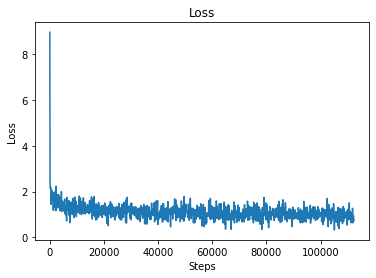

In [22]:
import matplotlib.pyplot as plt
   
steps = [i*100 for i in range(len(loss_per_10_steps))]
  
plt.plot(steps, loss_per_10_steps)
plt.title('Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

In [23]:
valid = pd.read_csv('/content/drive/MyDrive/project_2_data/task_2/task_2_event_summarization_valid.tsv', sep='\t')
valid['processed_interaction'] = valid['INTERACTION'].astype(str)
valid['processed_interaction'] = valid['processed_interaction'].map(interaction)
req_valid = list(valid.columns)
req_valid.remove('INTER1')
req_valid.remove('INTER2')
req_valid.remove('INTERACTION')
processed_valid_df = valid[req_valid]
processed_valid_df = processed_valid_df.fillna('')
temp2 = processed_valid_df
temp2['input_text'] = temp2.apply(convert_to_text, axis=1)

In [24]:
temp2['input_text']

0        EVENT_DATE: 19-January-2020 | SOURCE: Radio Ok...
1        EVENT_DATE: 24-December-2020 | SOURCE: Maghreb...
2        EVENT_DATE: 13-October-2021 | SOURCE: Citizen ...
3        EVENT_DATE: 29-March-2021 | SOURCE: Radio Tama...
4        EVENT_DATE: 10-September-2019 | SOURCE: Daily ...
                               ...                        
11698    EVENT_DATE: 06-April-2020 | SOURCE: This Day (...
11699    EVENT_DATE: 06-January-2020 | SOURCE: Studio T...
11700    EVENT_DATE: 08-February-2021 | SOURCE: Radio G...
11701    EVENT_DATE: 31-July-2020 | SOURCE: Mimi Mefo |...
11702    EVENT_DATE: 31-May-2018 | SOURCE: Sowetan (Sou...
Name: input_text, Length: 11703, dtype: object

In [25]:
valid_df = temp2[['input_text', 'NOTES']].rename(columns={'NOTES': 'target_text'})

In [26]:
valid_df.head()

,input_text,target_text
0,EVENT_DATE: 19-January-2020 | SOURCE: Radio Ok...,"On 19 January 2020, Mayi-Mayi armed men (unide..."
1,EVENT_DATE: 24-December-2020 | SOURCE: Maghreb...,"On 24 December 2020, the Algerian police dispe..."
2,EVENT_DATE: 13-October-2021 | SOURCE: Citizen ...,"On 13 October 2021, residents and business peo..."
3,EVENT_DATE: 29-March-2021 | SOURCE: Radio Tama...,"On 29 March 2021, armed youth from the Leer su..."
4,EVENT_DATE: 10-September-2019 | SOURCE: Daily ...,10 September. Peaceful Ashura processions of I...


In [27]:
inputvalidbatch = []
labelvalidbatch = []
# valid_df = valid_df.iloc[:100,:]
for indx,row in valid_df.iterrows():
  input = row['input_text']+'</s>' 
  labels = row['target_text']+'</s>'   
  inputvalidbatch.append(input)
  labelvalidbatch.append(labels)
inputvalidbatch=tokenizer.batch_encode_plus(inputvalidbatch,padding=True,max_length=400,return_tensors='pt')["input_ids"]
labelvalidbatch=tokenizer.batch_encode_plus(labelvalidbatch,padding=True,max_length=400,return_tensors="pt") ["input_ids"]
inputvalidbatch=inputvalidbatch.to(dev)
labelvalidbatch=labelvalidbatch.to(dev)

outputs = model.generate(inputvalidbatch)


In [28]:
outputs[0]

tensor([    0,   461,   957,  1762,  6503,     6,   932,    23,    18, 15881,
           23, 31428,   904,  4792,     3,     9,   388,    16,  2318,  4606],
       device='cuda:0')

In [29]:
o = []
for i in range(100):
  o.append(tokenizer.decode(outputs[i]))

In [30]:
print(o[46])
print(valid_df['target_text'].iloc[46])

<pad> 19 April 2019. The NISS defused a bomb in Mulongwe, Rut
Weapons seizure: On 19 April 2019, Intelligence officers arrested a woman carrying 23 magazines of ammunition and 690 cartridges in Mulongwe (Uvira, Sud-Kivu). The woman was detained while boarding a bus to Fizi, with the ammunition hidden in her luggage.


In [31]:
# !pip install rouge/requirements.txt
# !pip install rouge-score
!pip install rouge

In [32]:
from rouge import Rouge
rouge = Rouge()

rouge.get_scores(o, tokenizer.batch_decode(labelvalidbatch), avg=True)

{'rouge-1': {'f': 0.37471749103654617,
  'p': 0.6476638639138638,
  'r': 0.27245408274793875},
 'rouge-2': {'f': 0.1839816775908736,
  'p': 0.35085869685869686,
  'r': 0.1288264317706337},
 'rouge-l': {'f': 0.3586080856231334,
  'p': 0.6186309385059383,
  'r': 0.26095274501583055}}